<a href="https://colab.research.google.com/github/amoyag/GNN/blob/main/GNN_BS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A Graph Neural Network (GNN) model that's educational and suitable for a systems biology workshop. It's designed to analyze biological networks like protein-protein interactions or metabolic pathways. It uses PyTorch Geometric:

1. The `BiologyGNN` class is a simple GNN with:
   - 3 graph convolutional layers
   - ReLU activation functions
   - Dropout for regularization
   - A final linear layer for classification

2. Helper functions include:
   - `create_example_dataset()`: Creates a sample biological network
   - `train_model()`: Handles the training loop



In [3]:
# check PyTorch and CUDA versions

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.5.1+cu121
CUDA available: False
CUDA version: 12.1


In [4]:

# use those exact versions in the installation
!pip install torch-geometric pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu121.html

# check the installation
import torch_geometric
print(f"PyG version: {torch_geometric.__version__}")

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.6 MB/s eta 0:00:00
PyG version: 2.6.1


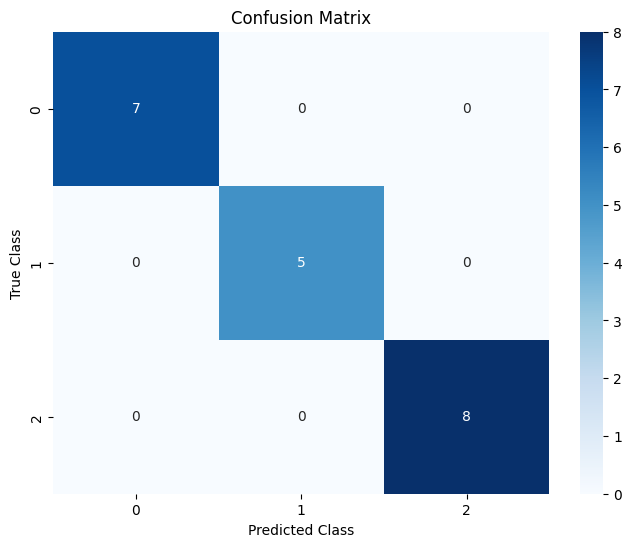


Model Performance:
Overall Accuracy: 100.0%

Class 0:
Precision: 100.0%
Recall: 100.0%
F1 Score: 100.0%

Class 1:
Precision: 100.0%
Recall: 100.0%
F1 Score: 100.0%

Class 2:
Precision: 100.0%
Recall: 100.0%
F1 Score: 100.0%


In [12]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
import numpy as np

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Add this at the start of your main code
set_seed(42)  # or any other number

class BiologyGNN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_channels=64):
        super(BiologyGNN, self).__init__()

        # Graph Convolutional layers
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        # Output layer
        self.linear = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # First Graph Convolution Layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)

        # Second Graph Convolution Layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)

        # Third Graph Convolution Layer
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Output Layer
        x = self.linear(x)

        return F.log_softmax(x, dim=1)

def create_example_dataset():
    """Create a simple example biological network dataset"""
    # Create a random graph
    G = nx.random_geometric_graph(20, 0.3)

    # Convert to edge index format
    edge_index = torch.tensor([[e[0] for e in G.edges()],
                             [e[1] for e in G.edges()]], dtype=torch.long)

    # Create random node features (could represent gene expression, protein properties, etc.)
    num_node_features = 10
    x = torch.randn((20, num_node_features))

    # Create random node labels (could represent protein function, pathway membership, etc.)
    y = torch.randint(0, 3, (20,))

    # Create PyG Data object
    data = Data(x=x, edge_index=edge_index, y=y)
    return data

def train_model(model, data, epochs=100):
    """Train the GNN model"""
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}, Loss: {loss:.4f}')



#### Evaluate the model



def evaluate_model(model, data):
    """Evaluate model performance with multiple metrics"""
    model.eval()
    with torch.no_grad():
        # Get predictions
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        true = data.y

        # Calculate metrics
        accuracy = accuracy_score(true, pred) * 100
        precision, recall, f1, _ = precision_recall_fscore_support(true, pred, average=None)
        conf_matrix = confusion_matrix(true, pred)

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.show()

        # Print results
        print(f"\nModel Performance:")
        print(f"Overall Accuracy: {accuracy:.1f}%")
        for i in range(len(precision)):
            print(f"\nClass {i}:")
            print(f"Precision: {precision[i]*100:.1f}%")
            print(f"Recall: {recall[i]*100:.1f}%")
            print(f"F1 Score: {f1[i]*100:.1f}%")








In [11]:

# Example usage for workshop
if __name__ == "__main__":
    # Create example dataset
    data = create_example_dataset()

    # Initialize model
    model = BiologyGNN(num_node_features=10, num_classes=3)

    # Train model
    train_model(model, data)

    # Make predictions
    model.eval()
    pred = model(data.x, data.edge_index)
    predicted_classes = pred.argmax(dim=1)
    print("\nPredicted classes:", predicted_classes)

Epoch 010, Loss: 0.7549
Epoch 020, Loss: 0.5883
Epoch 030, Loss: 0.5117
Epoch 040, Loss: 0.2982
Epoch 050, Loss: 0.3072
Epoch 060, Loss: 0.4154
Epoch 070, Loss: 0.2397
Epoch 080, Loss: 0.5071
Epoch 090, Loss: 0.1798
Epoch 100, Loss: 0.1744

Predicted classes: tensor([2, 0, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 2, 0, 1, 2, 2, 0, 1])


### Break down of the results:


1. The Loss Values (Epoch lines):
  - These show how well the model is learning over time (epochs). Loss starts high and decreases, which means means better performance. It shows the model is learning successfully

  Loss is a measure of how wrong the model's predictions are. Think of it as the "error score" - the lower the loss, the better the model is performing.

  The code
  ```python
  loss = F.nll_loss(out, data.y)
```
  tells the system to: make predictions (`out`). We compare these predictions to the true labels (`data.y`). The loss function calculates how far off our predictions are This loss value guides the model in adjusting its parameters to make better predictions.

  
  Think of training a neural network like teaching someone to play a pattern recognition game. In our case, the model is trying to guess which category (0, 1, or 2) each node in the network belongs to. Every time it makes a guess, it gets feedback in the form of a loss value —essentially a score of how many mistakes it made. The model then uses this feedback to adjust its strategy and make better guesses next time, with a lower loss value indicating fewer mistakes.

In the context of biological networks, this becomes particularly meaningful. For instance, the model might be trying to predict whether specific proteins are involved in cancer (class 0) or not (class 1). The loss value would indicate how accurate these predictions are, with a theoretical perfect score of 0 meaning the model correctly identified every protein's role. However, achieving such perfect prediction is rarely possible in practice due to the complexity of biological systems and the inherent noise in biological data.

2. The Predicted Classes:
  ```
  tensor([0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 0, 1, 0, 0, 0, 0, 1])
  ```
  This shows the model's predictions for each of the 20 nodes (proteins/genes) in your example network, where:
  - Each number (0, 1, or 2) represents a different class
  - In this example, these are random classes since we used `create_example_dataset()`
  - In a real biological context, these could represent:
    - Protein functions
    - Pathway membership
    - Disease association
    - Any other categorical property you're trying to predict

  However, it's important to note that this is using synthetic data where:
  - The network structure is random (from `nx.random_geometric_graph`)
  - The node features are random (from `torch.randn`)
  - The true labels are random (from `torch.randint`)

### About the model and the data
The Graph Neural Network (GNN) used here is designed to learn patterns from network-structured biological data. The model architecture consists of three graph convolutional layers (GCNConv) followed by a final linear layer. Each convolutional layer learns to aggregate information from neighboring nodes, meaning each protein learns from the proteins it interacts with. After each convolution, the model applies a ReLU activation function and dropout (with probability 0.1) to prevent overfitting. The final linear layer maps the learned representations to class probabilities using softmax, effectively making predictions about which category each protein belongs to.

The data structure represents a simplified biological network with 20 nodes (proteins) connected randomly using NetworkX's geometric graph generator. Each protein in this network has 10 random features (data.x), which in a real biological context could represent properties like expression levels, molecular weight, or sequence characteristics. The connections between proteins (edges) are established with a proximity threshold of 0.3, meaning proteins are connected if they're within this geometric distance of each other. Each protein is also randomly assigned one of three classes (0, 1, or 2; data.y), simulating a classification task like predicting protein function or disease association. While this synthetic data helps demonstrate how the model works, in a real application you'd replace these random elements with actual protein interaction data, meaningful biological features, and known functional annotations.

### About training the GNN

Think of the ground truth classes (data.y) as labels we already know, like having a set of proteins where we know their functions (some are enzymes, some are transporters, etc.). The model doesn't use these labels to make its predictions - instead, it uses two other pieces of information: the protein features (data.x) and who interacts with whom (edge_index).

When making a prediction, the model looks at each protein and considers:
1. The protein's own features (like its molecular weight, sequence properties, etc.)
2. The features of proteins it's connected to in the network (its interaction partners)

Through the training process, the model learns patterns like "proteins with these features that interact with these types of partners tend to be class 1." It's similar to how biologists might infer a protein's function by looking at its properties and what other proteins it interacts with. The model is essentially trying to rediscover the relationship between these patterns and the known classes.

Then we compare the model's predictions to those ground truth labels to see how well it learned these patterns. This is where the loss comes in —it measures how different the predictions are from the real classes we knew all along.

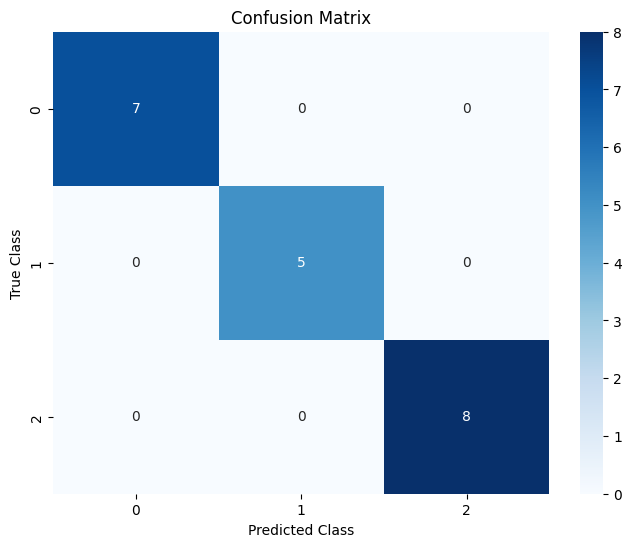


Model Performance:
Overall Accuracy: 100.0%

Class 0:
Precision: 100.0%
Recall: 100.0%
F1 Score: 100.0%

Class 1:
Precision: 100.0%
Recall: 100.0%
F1 Score: 100.0%

Class 2:
Precision: 100.0%
Recall: 100.0%
F1 Score: 100.0%


In [13]:
#@title Model evaluation
#Use this with your existing model and data
evaluate_model(model, data)

### About the evaluation parmeters


**Accuracy** is the most straightforward metric - it's simply the percentage of proteins that the model classified correctly. However, accuracy alone can be misleading, especially if the classes are imbalanced (like having many more proteins of one class than others).

**Precision** tells us, when the model predicts a specific class, how often it's correct. For example, if the model has 80% precision for class 0, it means that when it predicts a protein belongs to class 0, it's right 80% of the time. This is particularly important when false positives are costly.

**Recall** (also called sensitivity) shows how many proteins of a particular class the model actually found. If the recall for class 1 is 70%, it means the model correctly identified 70% of all proteins that truly belong to class 1. This matters when missing cases would be problematic.

The **F1 score** balances precision and recall into a single number. It's particularly useful when you need to find a sweet spot between not missing true cases (recall) and not making false predictions (precision). An F1 score of 100% would mean perfect precision and recall.

The confusion matrix provides a complete picture of the model's predictions. Each row represents the actual class, and each column shows what the model predicted. The numbers on the diagonal show correct predictions, while off-diagonal numbers show mistakes. This helps identify which classes the model commonly confuses with each other.

### Deep dive on the data


We're working with a network of 20 proteins, where each protein has 10 numerical features associated with it. These features are currently random numbers that simulate real protein properties - in a real biological context, they might represent characteristics like molecular weight, sequence patterns, or expression levels.

The network's structure is defined by connections between proteins, which we call edges. Each edge represents a potential interaction between two proteins, created using a geometric proximity rule - proteins that are "closer" to each other in our simulated space are connected. This gives us a pattern of connections that mimics real protein interaction networks, though in a simplified way. We can visualize this network as a graph where each protein is a node, and lines between nodes show their interactions.

Each protein in our network is also assigned to one of three classes (0, 1, or 2). These class assignments are currently random, but in a real biological context, they might represent functional categories, like whether a protein is an enzyme or a transcription factor. The distribution of these classes tells us how many proteins belong to each category.

To understand the network's overall structure, we can look at metrics like the average number of interactions per protein (average degree) and network density, which tells us how many of the possible connections between proteins actually exist. These properties help us understand how tightly connected our protein network is. The network visualization shows us this structure spatially, with different colors representing the different classes, giving us a visual sense of how proteins of different types are distributed through the network.

The GNN learns by combining and processing two key types of information for each protein: its own **features** and the features of proteins it **interacts** with. During each pass through the network (using the three **graph convolutional layers**), a protein's **representation** is updated by **aggregating information** from its neighbors. Think of it like each protein getting a better understanding of its role not just from its own characteristics, but also from the company it keeps in the interaction network. Each layer of the GNN allows this information to spread further through the network, so proteins eventually gain information from both **direct interaction partners** and more **distant connections**.

The model's **learning process** involves finding patterns between these combined feature representations and the **class assignments**. For example, it might learn that proteins with certain feature values that interact with proteins having complementary features tend to belong to a particular class. The **weights** in the convolutional layers are adjusted through training to better capture these patterns. When the model makes a **prediction** for a protein, it's essentially saying "based on this protein's features and the features of its interaction partners, it shows patterns similar to other proteins of class X that I've seen during training." The effectiveness of this learning process depends heavily on how **informative** the features are and how **meaningful** the network structure is, which is why using real biological data with actual protein properties and verified interactions would give more meaningful results than our random example.

In [14]:

def examine_network_data(data):
    """Examine and display network data features"""
    # Print basic information
    print(f"Number of nodes (proteins): {data.x.shape[0]}")
    print(f"Number of features per node: {data.x.shape[1]}")
    print(f"Number of edges (interactions): {data.edge_index.shape[1]}")
    print(f"\nFeature matrix shape: {data.x.shape}")

    # Show example of features for first few nodes
    print("\nExample features for first 3 proteins:")
    for i in range(3):
        print(f"Protein {i} features: {data.x[i].numpy()}")

    # Show class distribution
    unique_classes, counts = torch.unique(data.y, return_counts=True)
    print("\nClass distribution:")
    for class_idx, count in zip(unique_classes, counts):
        print(f"Class {class_idx}: {count} proteins")

    # Visualize network
    G = nx.Graph()
    edge_list = data.edge_index.t().numpy()
    for edge in edge_list:
        G.add_edge(edge[0], edge[1])

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos,
            node_color=data.y,  # Color nodes by their class
            node_size=500,
            cmap=plt.cm.viridis)
    plt.title("Network Structure (colors represent classes)")
    plt.show()

    return G



Number of nodes (proteins): 20
Number of features per node: 10
Number of edges (interactions): 35

Feature matrix shape: torch.Size([20, 10])

Example features for first 3 proteins:
Protein 0 features: [ 1.2418567   0.8587465   0.35895437  0.313394    0.562753    1.0735687
 -0.5000297  -0.09579299 -1.4015703   2.2647078 ]
Protein 1 features: [-0.48789662 -0.5088653   0.02540668  0.83918    -1.8238322   0.7640924
  0.53072244  0.08588719 -0.4223914   0.4597543 ]
Protein 2 features: [-1.1807002  -1.6019034   0.28961647 -0.18309517  1.7251742  -0.55146515
 -0.9939936   1.8062181  -0.5488963   1.1739764 ]

Class distribution:
Class 0: 7 proteins
Class 1: 5 proteins
Class 2: 8 proteins


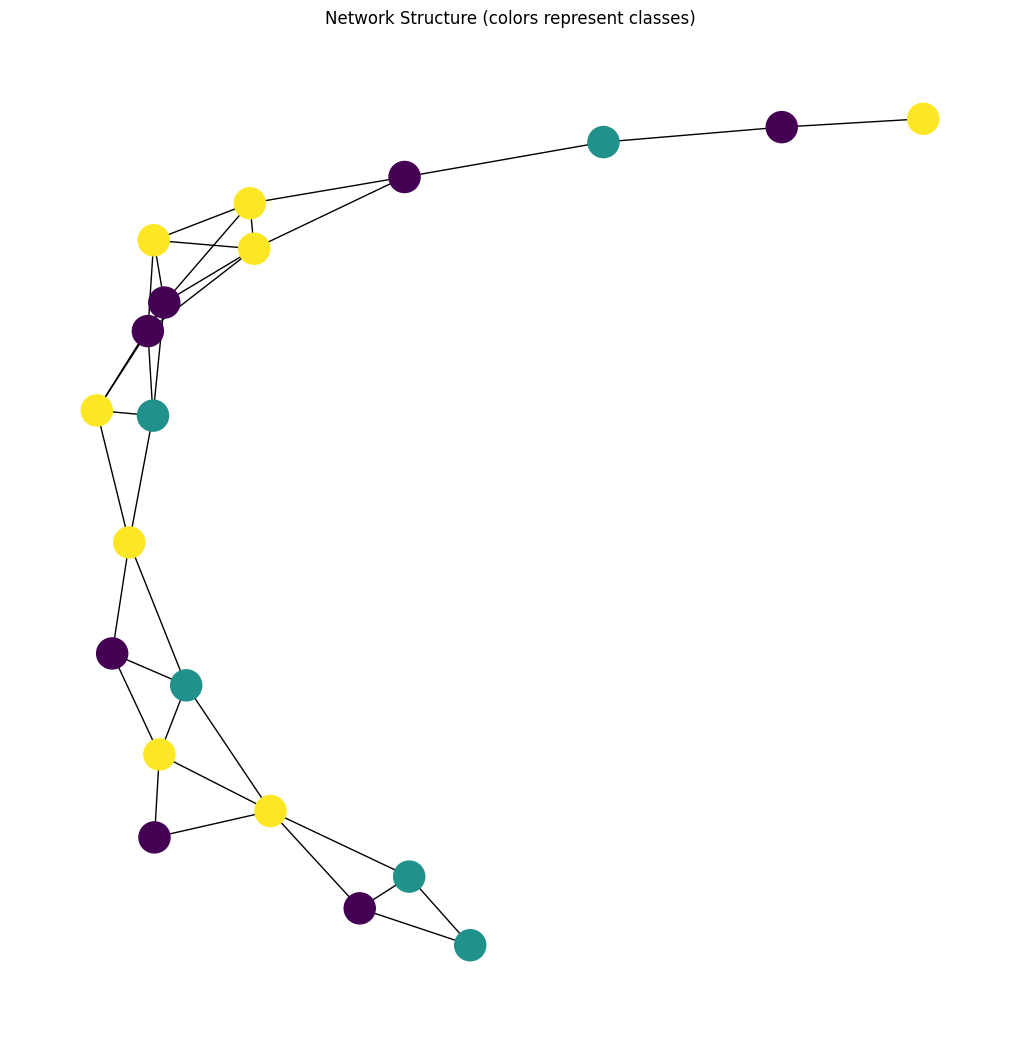


Average number of interactions per protein: 3.50
Network density: 0.184


In [15]:
# examine the  dataset
#data = create_example_dataset()
G = examine_network_data(data)

# Additional network analysis
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print(f"\nAverage number of interactions per protein: {avg_degree:.2f}")
print(f"Network density: {nx.density(G):.3f}")

### Going a step further

In a real-world scenario, we often face situations where not all proteins in a network have known functions or classifications. This is where Graph Neural Networks become particularly valuable. Rather than requiring complete class information for all proteins, GNNs can learn from partially labeled networks where only some proteins have known classes. The model learns patterns from the proteins with known classifications and uses these patterns, along with protein features and network structure, to predict the classes of unlabeled proteins.

For example, in a network of 20 proteins, we might only know the functional classes of 17 proteins. The GNN can learn from these 17 proteins and predict the functions of the remaining 3 based on their features and their interactions with proteins of known function. This capability is especially valuable in biology since experimentally determining protein functions is time-consuming and expensive, while interaction data and protein features are often more readily available. The model essentially leverages what we already know about some proteins to make educated predictions about others.





The `create_partially_labeled_dataset()` function creates our test network with some proteins having unknown classes. It uses `random_geometric_graph` to generate the network structure and creates `num_features` random features for each protein. The key difference is that it marks some proteins as unknown by setting their class labels to `-1`. It selects which proteins to leave unlabeled using `torch.randperm` to randomly pick `num_unlabeled` proteins. Like our original dataset creation, it packages everything into a `Data` object containing the features (`x`), connections (`edge_index`), and labels (`y`).

The `train_with_partial_labels()` function modifies the training process to handle unlabeled proteins. It creates a `labeled_mask` to identify which proteins have known classes, and only uses these proteins for calculating the `loss`. The function still uses an `Adam` optimizer, but now it only compares the model's predictions against the known class labels, ignoring the proteins marked with `-1`. This lets the model learn from the labeled proteins while skipping the unlabeled ones during training.

The `predict_unknown_classes()` function takes our trained model and uses it to predict classes for the unlabeled proteins. It puts the model in evaluation mode with `model.eval()` and uses `torch.no_grad()` since we're not training anymore. It generates predictions for all proteins using the model, then uses an `unlabeled_mask` to find proteins with `-1` labels. For these proteins, it reports what class the model predicts based on their features and their connections to labeled proteins in the network.

In [16]:
def create_partially_labeled_dataset(num_nodes=20, num_unlabeled=3):
    """Create a dataset where some proteins have unknown classes"""
    # Create basic dataset
    G = nx.random_geometric_graph(num_nodes, 0.3)
    edge_index = torch.tensor([[e[0] for e in G.edges()],
                             [e[1] for e in G.edges()]], dtype=torch.long)

    # Create features
    num_features = 10
    x = torch.randn((num_nodes, num_features))

    # Create labels, marking some as unknown (-1)
    y = torch.randint(0, 3, (num_nodes,))

    # Randomly select nodes to be unlabeled
    unlabeled_indices = torch.randperm(num_nodes)[:num_unlabeled]
    y[unlabeled_indices] = -1  # -1 indicates unknown class

    data = Data(x=x, edge_index=edge_index, y=y)
    return data

def train_with_partial_labels(model, data):
    """Train model using only labeled nodes"""
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Get mask for labeled nodes
    labeled_mask = data.y != -1

    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)

        # Calculate loss only on labeled nodes
        loss = F.nll_loss(out[labeled_mask], data.y[labeled_mask])
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d}, Loss: {loss:.4f}')

def predict_unknown_classes(model, data):
    """Predict classes for unlabeled nodes"""
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)

        # Show predictions for unlabeled nodes
        unlabeled_mask = data.y == -1
        print("\nPredictions for unlabeled proteins:")
        for i in range(len(data.y)):
            if unlabeled_mask[i]:
                print(f"Protein {i}: Predicted Class {pred[i].item()}")

In [18]:
# reate the partially labeled dataset
data = create_partially_labeled_dataset(num_nodes=20, num_unlabeled=3)

# Initialize and train the model
# use the prevoius model
# model = BiologyGNN(num_node_features=10, num_classes=3)
train_with_partial_labels(model, data)

# Get predictions for unlabeled proteins
predict_unknown_classes(model, data)

Epoch 010, Loss: 0.8220
Epoch 020, Loss: 0.7775
Epoch 030, Loss: 0.6352
Epoch 040, Loss: 0.5812
Epoch 050, Loss: 0.4523
Epoch 060, Loss: 0.4013
Epoch 070, Loss: 0.4809
Epoch 080, Loss: 0.3208
Epoch 090, Loss: 0.2831
Epoch 100, Loss: 0.3305

Predictions for unlabeled proteins:
Protein 5: Predicted Class 0
Protein 9: Predicted Class 1
Protein 14: Predicted Class 2
